Model is single hidden layer: x -> n_h -> y  (size of x and y is equal)

W1 = (n_h, x), W2 = (y, n_h)
x = 3 features (should be able to vary this)
y = abs(x) 
n_h = 2 neurons (should be able to vary this)
loss = MSE

- Vary the activation function used in each layer (e.g. ReLU or identity, by default, ReLU)

- Vary the bias value used in each layer (all equal or specific values)

- Vary the feature sparsity (all equal or specific values (e.g. function of index))

- Vary the feature importance (all equal or specific values (e.g. function of index))

- Vary the loss fn

- Optional: Vary optimizer and lr schedule

In [62]:
"""Notebook settings and imports."""

%load_ext autoreload
%autoreload 2
# %flow mode reactive

import os

from dataclasses import dataclass, field
from typing import Callable, List, Optional, Tuple, Union

import numpy as np
import torch as t

from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from plotly import express as px
from plotly import graph_objects as go
from plotly import io as pio
from rich import print as rprint
from torch import nn, optim
from torch.nn import functional as F
from tqdm.notebook import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
@dataclass
class CisConfig:
    n_instances: int = 2
    n_feat: int = 2
    n_hidden: int = 4
    act_fn: List[Callable] = field(default_factory=lambda: [F.relu, F.relu])
    b1: str | Float[t.Tensor, "inst hid"] = field(default_factory=lambda: "0")
    b2: str | Float[t.Tensor, "inst hid"] = field(default_factory=lambda: "0")
    feat_sparsity: float| t.Tensor = 0
    feat_importance: float | t.Tensor = 1.0
    optimizer: Callable = t.optim.Adam

    def __post_init__(self):
        """Ensure attribute values are valid."""
        pass

In [64]:
class Cis(nn.Module):
    """Computation in Superposition toy model."""

    # Some attribute type hints
    W1: Float[t.Tensor, "inst feat hid"]
    W2: Float[t.Tensor, "inst hid feat"]
    b1: Float[t.Tensor, "inst hid"]
    b2: Float[t.Tensor, "inst feat"]
    s: Float[t.Tensor, "inst feat"]  # feature sparsity
    i: Float[t.Tensor, "inst feat"]  # feature importance


    def __init__(self, cfg: CisConfig):
        """Initializes model params."""
        super().__init__()
        self.cfg = cfg

        # Model Weights
        self.W1 = nn.Parameter(nn.init.xavier_normal_(t.empty(cfg.n_instances, cfg.n_feat, cfg.n_hidden)))
        self.W2 = nn.Parameter(nn.init.xavier_normal_(t.empty(cfg.n_instances, cfg.n_hidden, cfg.n_feat)))

        # Model Biases
        # self.b1 = nn.Parameter(t.zeros(cfg.n_instances, cfg.n_hidden)) if cfg.b1 == "0" else cfg.b1
        self.b1 = t.zeros(cfg.n_instances, cfg.n_hidden) if cfg.b1 == "0" else cfg.b1
        self.b2 = nn.Parameter(t.zeros(cfg.n_instances, cfg.n_feat)) if cfg.b2 == "0" else cfg.b2

        # Sparsities
        if isinstance(cfg.feat_sparsity, float):
            self.s = t.full((cfg.n_instances, cfg.n_feat), cfg.feat_sparsity)
        else:
            self.s = cfg.feat_sparsity

        # Importances
        if isinstance(self.cfg.feat_importance, float):
            self.i = t.full((self.cfg.n_feat,), self.cfg.feat_importance)
        elif callable(self.cfg.feat_importance):
            self.i = cfg.feat_importance


    def gen_batch(self, batch_sz: int) -> Float[t.Tensor, "batch inst feat"]:
        """Generates a batch of data (sparse feature vals on [-1, 1])."""

        # Randomly generate features vals, and for each, randomly determine which samples are non-zero
        x = t.rand(batch_sz, self.cfg.n_instances, self.cfg.n_feat) * 2 - 1  # [-1, 1]
        is_active = t.rand(batch_sz, self.cfg.n_instances, self.cfg.n_feat) < (1 - self.s)
        
        return x * is_active


    def forward(
        self, x: Float[t.Tensor, "batch inst feat"], fx: Callable = t.abs
    ) -> Float[t.Tensor, ""]:
        """Runs a forward pass through model returning the loss."""

        # Hidden layer
        h = einsum(x, self.W1, "batch inst feat, inst feat hid -> batch inst hid")
        h = self.cfg.act_fn[0](h + self.b1)

        # Output layer
        y = einsum(h, self.W2, "batch inst hid, inst hid feat -> batch inst feat")
        y = self.cfg.act_fn[1](y + self.b2)

        # Compute weighted MSE loss
        y_true = fx(x)
        loss = reduce(((y - y_true) ** 2 * self.i), "batch inst feat -> ", "mean")

        return loss


    def optimize(
        self, optimizer: t.optim.Optimizer, batch_sz: int, steps: int, logging_freq: int
    ):
        """Optimizes the model."""

        losses = []
        pbar = tqdm(range(steps), desc="Training")

        for step in pbar:
            x = self.gen_batch(batch_sz)
            loss = self.forward(x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Log progress
            if step % logging_freq == 0 or (step + 1 == steps):
                losses.append(loss.item())
                pbar.set_postfix({"loss": f"{loss.item():.4f}"})

        return losses

In [ ]:
config = CisConfig(n_instances=1, n_feat=100, n_hidden=40, feat_sparsity=0.7, feat_importance=1.0)
model = Cis(config)
batch_sz = 128
steps = 10000
logging_freq = steps // 10

model.optimize(t.optim.Adam(model.parameters()), batch_sz, steps, logging_freq)

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

[0.099042609333992,
 0.06484565883874893,
 0.06373614072799683,
 0.06357651948928833,
 0.061400171369314194,
 0.06281690299510956,
 0.06355323642492294,
 0.06354673206806183,
 0.06392452120780945,
 0.0648106187582016,
 0.065337173640728]

In [184]:
def count_monosemantic_neurons(matrix, threshold=0.01):
    """
    Counts the number of elements which are more than the threshold (in absolute value) in each column.
    
    Args:
        matrix: Input numpy array
        threshold: Values above this threshold will be counted (default: 0.01)
    
    Returns:
        numpy array with counts of elements above the threshold for each column
    """
    # Compute the count of elements above the threshold for each column
    counts = np.sum(np.abs(matrix) > threshold, axis=0)
    c1s = len([n for n in counts if n == 1])
    #print(counts, c1s)
    return c1s

In [185]:
def threshold_matrix(matrix, threshold=0.01):
    """
    Sets matrix elements to zero if their absolute value is below the threshold.
    
    Args:
        matrix: Input numpy array
        threshold: Values below this threshold will be set to 0 (default: 1e-10)
    
    Returns:
        numpy array with small values set to zero
    """
    # Create a copy to avoid modifying the original matrix
    result = np.copy(matrix)
    
    # Set elements below threshold to zero
    result[np.abs(result) < threshold] = 0
    
    return result

In [ ]:
feat_sparsities = np.linspace(0.0, 0.99, 100)
losses = []
counts = []
Ws = []

for feat_sparsity in feat_sparsities:
    config = CisConfig(n_instances=1, n_feat=100, n_hidden=40, feat_sparsity=feat_sparsity, feat_importance=1.0)
    model = Cis(config)
    batch_sz = 128
    steps = 10000
    logging_freq = steps // 10

    model.optimize(t.optim.Adam(model.parameters()), batch_sz, steps, logging_freq)
    cur_w = model.W1.detach().numpy().squeeze()
    Ws.append(cur_w)
    count = count_monosemantic_neurons(cur_w, threshold=0.1)    
    counts.append(count)
    print(feat_sparsity, count)

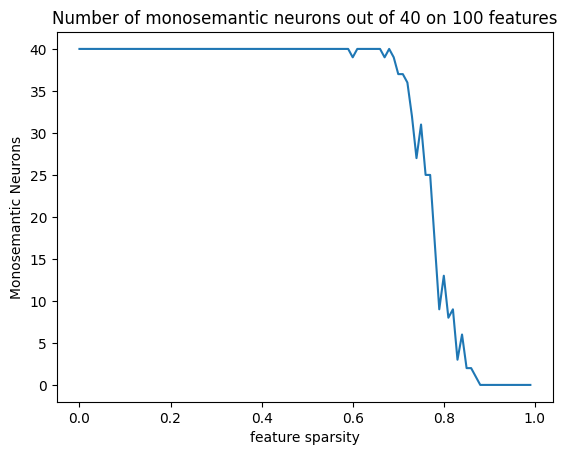

In [217]:

plt.plot(feat_sparsities, counts)
plt.title('Number of monosemantic neurons out of 40 on 100 features')
plt.xlabel('feature sparsity')
plt.ylabel('Monosemantic Neurons')
plt.show()

In [167]:
def plot_polysemanticity(W1):
    import matplotlib.pyplot as plt

    # Define the weight matrix
    #W1 = model.W1.detach().numpy().squeeze()
    W1 = threshold_matrix(W1)

    # Create feature labels
    features = [f'Feature {i+1}' for i in range(W1.shape[0])]

    # Extend x range by one point to show the last step
    x = np.arange(W1.shape[1] + 1)
    # Extend the weight matrix data by repeating the last column
    W1_extended = np.hstack([W1, W1[:, -1:]])

    # Create larger figure
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create stack plot with extended data
    ax.stackplot(x, W1_extended, labels=features, step='post')
    ax.set_xlim(-0.1, W1.shape[1] - 0.1)  # Set limit to show exactly 6 stacks

    # Enhance visibility
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

    # Set titles and labels
    ax.set_title('Non-Continuous Stack Plot of W1')
    ax.set_xlabel('Data Points')
    ax.set_ylabel('Values')

    # Add x-ticks for each neuron
    ax.set_xticks(np.arange(W1.shape[1]))
    ax.set_xticklabels([f'Neuron {i+1}' for i in range(W1.shape[1])])

    # Adjust layout to prevent cutoff
    plt.tight_layout()

    # Show the plot
    plt.show()